# EchoBot Data Processing Pipeline (v02)

**Annotated notebook for EchoBot data processing**  
Emmett Culhane — Translated from MATLAB (`echobot_pipeline_SCRIPTED.m`)

v02 additions: 3-sector overlay plots with target/tank-floor zoom, automated empty-region and tank-floor detection, summed-sector TS(f), and multi-ping noise characterization.

In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import firwin, lfilter, correlate, hilbert, spectrogram
from scipy.ndimage import uniform_filter1d, binary_dilation
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

# ---- Consistent color scheme ----
CLR_NOISE  = '#2ca02c'    # green  — noise / empty_shallow gates & FFT
CLR_TARGET = '#1f77b4'    # blue   — 38 mm target gates & FFT
CLR_DEEP   = '#ff7f0e'    # orange — empty_deep gates

## 1 — Load data file

09/04/2025 ‖ 38 & 22 mm targets ‖ 3 dB ‖ stationary target ‖ downsweep

In [2]:
mat_file = '../../Data/backcyl_bis_rgh0.01271_T143330_100.mat'

S = sio.loadmat(mat_file, squeeze_me=False)

# ---- Data & header ----
data = S['data']                        # (Ns, 5, Npings)
header = S['header'][0, 0]              # structured array -> scalar record

fs = float(header['fs'].flat[0])        # Hz
c  = float(header['c'].flat[0]) if 'c' in header.dtype.names else 1486.0  # m/s
rx_chans = [0, 1, 2]                    # sectors 1-3 (0-indexed)

print(f'fs = {fs/1e3:.1f} kHz   c = {c:.1f} m/s')
print(f'data shape: {data.shape}  ->  Ns={data.shape[0]}, channels={data.shape[1]}, Npings={data.shape[2]}')

fs = 2000.0 kHz   c = 1486.0 m/s
data shape: (101003, 5, 100)  ->  Ns=101003, channels=5, Npings=100


## 2 — Build axes and transmit reference chirp

In [3]:
Ns = data.shape[0]
t = np.arange(Ns) / fs                                  # time axis (s)

T_pre  = float(header['T_pre'].flat[0])
T_post = float(header['T_post'].flat[0])
R = 0.5 * c * (t - T_pre)                               # range axis (m)

# ---- Tx reference chirp ----
s_chirp = header['s_chirp'].flatten()
T_chirp = len(s_chirp) / fs

n_pre  = int(round(T_pre  * fs))
n_post = int(round(T_post * fs))
tx_ref = np.concatenate([np.zeros(n_pre), s_chirp, np.zeros(n_post)])

print(f'T_chirp = {T_chirp*1e3:.2f} ms   tx_ref length = {len(tx_ref)}')

T_chirp = 0.50 ms   tx_ref length = 101003


## 3 — Sanity check: transmit chirp spectrogram

Verify the chirp direction (downsweep for the 09/04 data).

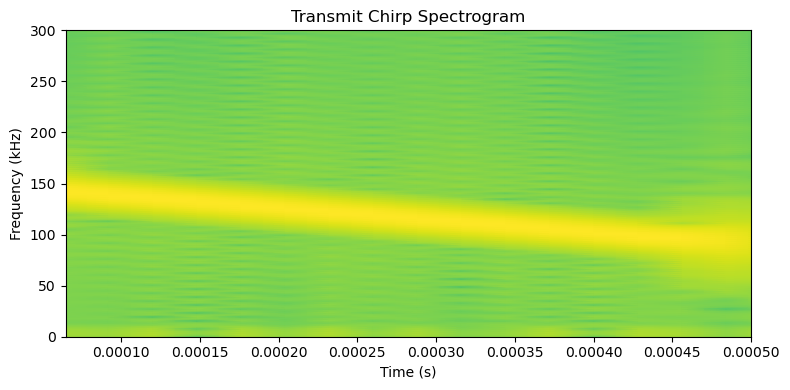

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
window = np.hamming(256)
f_spec, t_spec, Sxx = spectrogram(tx_ref, fs=fs, window=window, noverlap=200, nfft=1024)
ax.pcolormesh(t_spec, f_spec / 1e3, 10 * np.log10(Sxx + 1e-30), shading='gouraud')
ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')
ax.set_title('Transmit Chirp Spectrogram')
ax.set_xlim([0.000065, 0.0005])
ax.set_ylim([0, 300])      # kHz
plt.tight_layout()
plt.show()

## 4 — Find strongest / first / last ping indices

In [5]:
Npings = data.shape[2]

s = np.array([
    np.median(np.sqrt(np.mean(np.abs(data[:, :, p]) ** 2, axis=0)))
    for p in range(Npings)
])

start_idx = 0                                    # first ping (0-indexed)
end_idx   = Npings - 1                           # last ping
max_idx   = np.argmax(s[1:-1]) + 1               # strongest (excl. endpoints)

print(f'start_idx = {start_idx},  end_idx = {end_idx},  max_idx = {max_idx}')

start_idx = 0,  end_idx = 99,  max_idx = 58


## 5 — Matched filter processing

Using the **first ping** (`start_idx`).  
Band-pass via cascaded HP + LP FIR filters, then cross-correlate with `tx_ref`.

In [6]:
# Select the first ping
ping_idx = start_idx

# ---- Design FIR filters (matching MATLAB designfilt specs) ----
# Low-pass: passband 150 kHz, stopband 200 kHz
lp_numtaps = 101
lp_cutoff  = 175e3            # midpoint between pass & stop
lp_coeff   = firwin(lp_numtaps, lp_cutoff, fs=fs)

# High-pass: passband 90 kHz, stopband 70 kHz
hp_numtaps = 101
hp_cutoff  = 80e3             # midpoint between stop & pass
hp_coeff   = firwin(hp_numtaps, hp_cutoff, fs=fs, pass_zero=False)

def bandpass_filter(x):
    """Apply LP then HP (same order as MATLAB code)."""
    return lfilter(hp_coeff, 1.0, lfilter(lp_coeff, 1.0, x))

df1 = bandpass_filter(data[:, 0, ping_idx])
df2 = bandpass_filter(data[:, 1, ping_idx])
df3 = bandpass_filter(data[:, 2, ping_idx])

# ---- Cross-correlation with tx_ref ----
c1 = correlate(df1, tx_ref, mode='full')
c2 = correlate(df2, tx_ref, mode='full')
c3 = correlate(df3, tx_ref, mode='full')

# Lag vector (same convention as MATLAB xcorr)
n_df  = len(df1)
n_ref = len(tx_ref)
lags  = np.arange(-(n_ref - 1), n_df)     # full correlation lags

idx_pos = lags >= 0
Rmf = 0.5 * c * (lags[idx_pos] / fs)      # range axis for MF output
C   = np.column_stack([c1[idx_pos], c2[idx_pos], c3[idx_pos]])   # (N, 3)
cc_dB = 20 * np.log10(np.abs(hilbert(C, axis=0)) + 1e-30)

print(f'MF output shape: {C.shape}')

MF output shape: (101003, 3)


## 6 — Voltage time series (filtered, per sector)

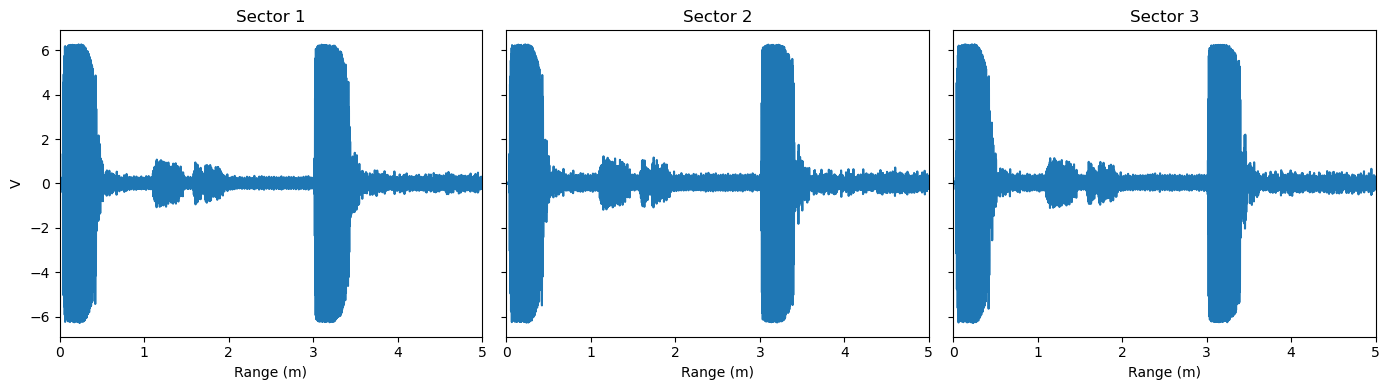

In [7]:
Range = 0.5 * c * (t - T_pre)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for ax, sig, ch in zip(axes, [df1, df2, df3], [1, 2, 3]):
    ax.plot(Range, sig)
    ax.set_xlim([0, 5])
    ax.set_title(f'Sector {ch}')
    ax.set_xlabel('Range (m)')
axes[0].set_ylabel('V')
plt.tight_layout()
plt.show()

## 7 — Utilities: tank floor detection & empty region finder

- **Tank floor**: the range of the greatest voltage peak (envelope) beyond the target window.  
- **Empty regions**: sliding-window search for the most uniform / lowest-energy 0.25 m window.  
  - `empty_shallow`: above the shallowest target peak  
  - `empty_deep`: below the deepest target peak (but above tank floor)

In [8]:
# ---- 38 mm target window (hard-coded for this test) ----
target_38mm_center = 1.57
target_38mm_half   = 0.25
target_38mm_band   = [target_38mm_center - target_38mm_half,
                      target_38mm_center + target_38mm_half]

# ---- Combined voltage envelope across all 3 sectors ----
voltage_envelope = np.abs(df1) + np.abs(df2) + np.abs(df3)


# ==================================================================
#  Signal-exclusion mask
#  Smooths the envelope, thresholds to find where signal is present,
#  then dilates by a safety margin so empty-region searches never
#  encroach on target / floor returns.
# ==================================================================
dr = Range[1] - Range[0]

smooth_samples = max(1, int(round(0.05 / dr)))          # ~5 cm smoothing
env_smooth = uniform_filter1d(voltage_envelope, smooth_samples)

# Threshold: 3x median of the positive-range portion of the envelope
signal_threshold = 3.0 * np.median(env_smooth[Range > 0.05])
signal_present = env_smooth > signal_threshold

# Dilate by 0.15 m on each side to create exclusion margin
margin_samples = int(round(0.15 / dr))
signal_zones = binary_dilation(signal_present, iterations=margin_samples)

print(f'Signal exclusion: {signal_zones.sum()} of {len(signal_zones)} samples flagged '
      f'({100*signal_zones.mean():.1f}%)')


# ==================================================================
#  Utilities
# ==================================================================
def find_tank_floor(range_axis, envelope, beyond_range):
    """Find the range of the peak voltage envelope beyond `beyond_range`."""
    mask = range_axis > beyond_range
    idx_offset = np.argmax(envelope[mask])
    idx_abs = np.flatnonzero(mask)[idx_offset]
    return range_axis[idx_abs], idx_abs


def find_empty_region(range_axis, envelope, search_lo, search_hi,
                      win_size=0.25, exclusion_mask=None):
    """Sliding-window search for the lowest-RMS region of width `win_size`
    within [search_lo, search_hi], avoiding any samples marked True in
    `exclusion_mask`.  Returns (center, half_width, band)."""
    win_samples = max(1, int(round(win_size / dr)))

    i_lo = np.searchsorted(range_axis, search_lo)
    i_hi = np.searchsorted(range_axis, search_hi, side='right')
    seg = envelope[i_lo:i_hi]

    if len(seg) < win_samples:
        raise ValueError(f'Search region [{search_lo:.2f}, {search_hi:.2f}] '
                         f'shorter than window size {win_size:.2f} m')

    # Cumulative sum for fast sliding-window energy
    cs = np.cumsum(seg ** 2)
    cs = np.insert(cs, 0, 0.0)
    win_energy = cs[win_samples:] - cs[:-win_samples]

    # If we have an exclusion mask, penalize any window that overlaps signal
    if exclusion_mask is not None:
        exc_seg = exclusion_mask[i_lo:i_hi].astype(float)
        cs_exc = np.cumsum(exc_seg)
        cs_exc = np.insert(cs_exc, 0, 0.0)
        win_exc_count = cs_exc[win_samples:] - cs_exc[:-win_samples]
        # Set energy to infinity for windows containing any excluded sample
        win_energy[win_exc_count > 0] = np.inf

    if np.all(np.isinf(win_energy)):
        raise ValueError(f'No signal-free window of size {win_size:.2f} m '
                         f'found in [{search_lo:.2f}, {search_hi:.2f}]')

    best = np.argmin(win_energy)
    center_idx = i_lo + best + win_samples // 2
    center_range = range_axis[center_idx]
    half = win_size / 2
    return center_range, half, [center_range - half, center_range + half]


# ---- Tank floor ----
tank_floor_range, tank_floor_idx = find_tank_floor(
    Range, voltage_envelope, beyond_range=target_38mm_band[1] + 0.3)

print(f'Tank floor detected at {tank_floor_range:.3f} m')


# ---- Empty regions (now respecting signal exclusion mask) ----
# empty_shallow: search from 0.1 m up to well before the tank max range,
#                the exclusion mask will automatically skip any target peaks
empty_shallow_center, empty_shallow_half, empty_shallow_band = find_empty_region(
    Range, voltage_envelope,
    search_lo=0.1,
    search_hi=target_38mm_band[0],
    win_size=0.25,
    exclusion_mask=signal_zones)

# empty_deep: search between target and tank floor
empty_deep_center, empty_deep_half, empty_deep_band = find_empty_region(
    Range, voltage_envelope,
    search_lo=target_38mm_band[1],
    search_hi=tank_floor_range,
    win_size=0.25,
    exclusion_mask=signal_zones)

print(f'empty_shallow band: [{empty_shallow_band[0]:.3f}, {empty_shallow_band[1]:.3f}] m  '
      f'(center {empty_shallow_center:.3f} m)')
print(f'empty_deep    band: [{empty_deep_band[0]:.3f}, {empty_deep_band[1]:.3f}] m  '
      f'(center {empty_deep_center:.3f} m)')

Signal exclusion: 33224 of 101003 samples flagged (32.9%)
Tank floor detected at 3.164 m
empty_shallow band: [0.706, 0.956] m  (center 0.831 m)
empty_deep    band: [2.080, 2.330] m  (center 2.205 m)


## 8 — 3-sector overlay voltage plots

Three figures:  
1. **Full range** — all 3 sectors overlaid  
2. **Target zoom** (centred at 1.57 m) — top subplot: 3 sectors; bottom: 3 sectors + sum  
3. **Tank floor zoom** (centred at detected floor) — same subplot layout

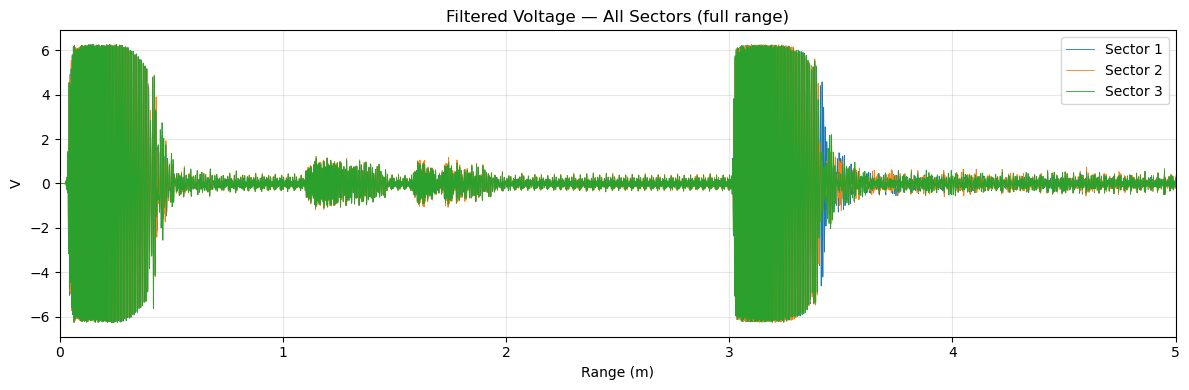

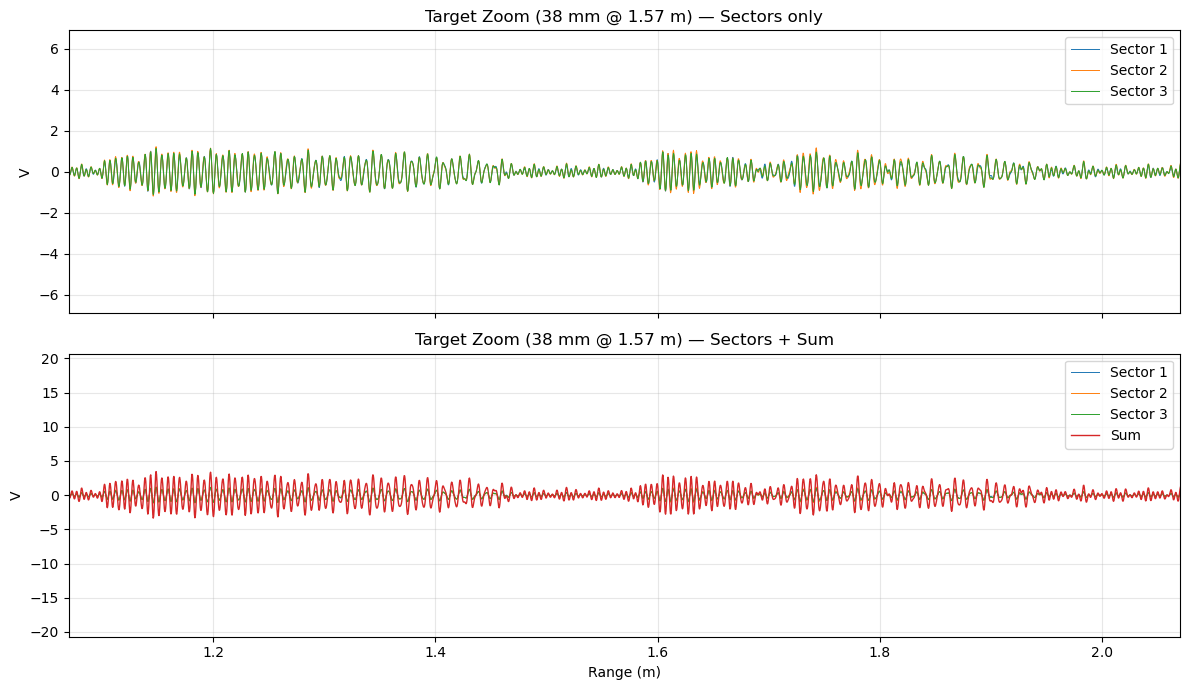

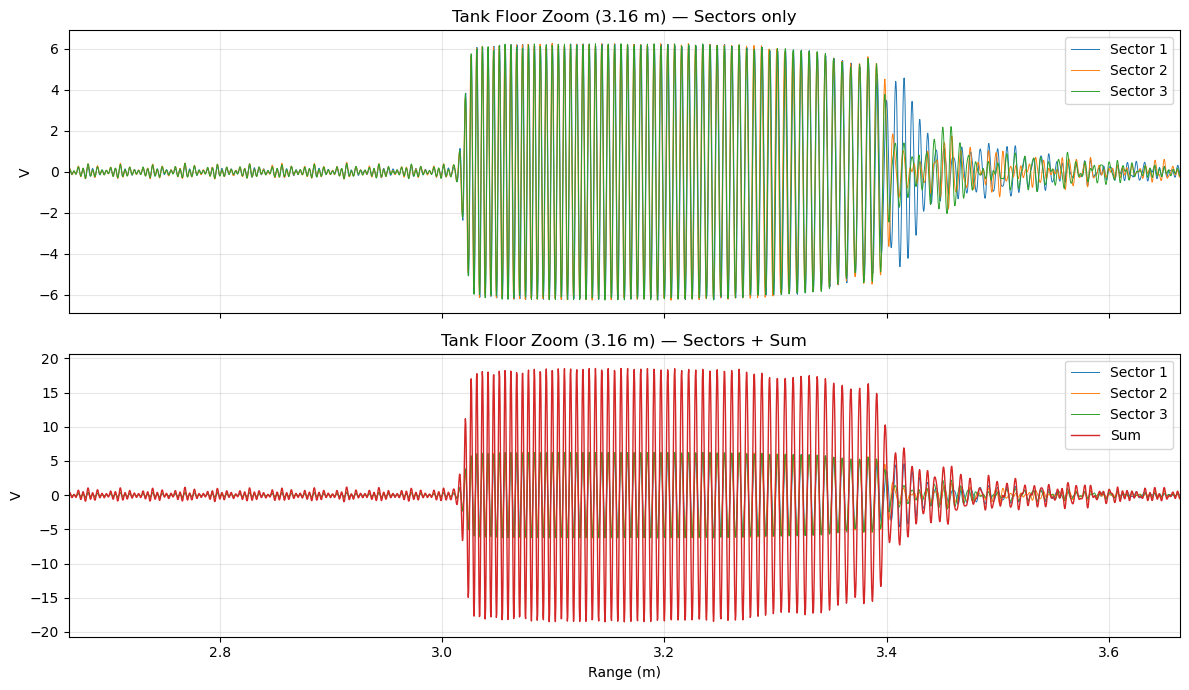

In [9]:
sector_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']   # blue, orange, green
sum_color     = '#d62728'                             # red for summed signal
df_sum = df1 + df2 + df3

# -------- (1) Full range --------
fig, ax = plt.subplots(figsize=(12, 4))
for sig, ch, col in zip([df1, df2, df3], [1, 2, 3], sector_colors):
    ax.plot(Range, sig, color=col, linewidth=0.6, label=f'Sector {ch}')
ax.set_xlim([0, 5])
ax.set_xlabel('Range (m)')
ax.set_ylabel('V')
ax.set_title('Filtered Voltage — All Sectors (full range)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# -------- Helper for the zoom subplots --------
def plot_zoom_pair(range_axis, sigs, df_sum, center, half_width, title_tag):
    """Two-row subplot: top = 3 sectors only, bottom = 3 sectors + sum."""
    xlims = [center - half_width, center + half_width]

    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    # Top: sectors only
    for sig, ch, col in zip(sigs, [1, 2, 3], sector_colors):
        ax_top.plot(range_axis, sig, color=col, linewidth=0.7, label=f'Sector {ch}')
    ax_top.set_xlim(xlims)
    ax_top.set_ylabel('V')
    ax_top.set_title(f'{title_tag} — Sectors only')
    ax_top.legend(loc='upper right')
    ax_top.grid(True, alpha=0.3)

    # Bottom: sectors + sum
    for sig, ch, col in zip(sigs, [1, 2, 3], sector_colors):
        ax_bot.plot(range_axis, sig, color=col, linewidth=0.7, label=f'Sector {ch}')
    ax_bot.plot(range_axis, df_sum, color=sum_color, linewidth=1.0, label='Sum')
    ax_bot.set_xlim(xlims)
    ax_bot.set_xlabel('Range (m)')
    ax_bot.set_ylabel('V')
    ax_bot.set_title(f'{title_tag} — Sectors + Sum')
    ax_bot.legend(loc='upper right')
    ax_bot.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# -------- (2) Target zoom --------
plot_zoom_pair(Range, [df1, df2, df3], df_sum,
               center=target_38mm_center, half_width=0.5,
               title_tag='Target Zoom (38 mm @ 1.57 m)')

# -------- (3) Tank floor zoom --------
plot_zoom_pair(Range, [df1, df2, df3], df_sum,
               center=tank_floor_range, half_width=0.5,
               title_tag=f'Tank Floor Zoom ({tank_floor_range:.2f} m)')

## 9 — Matched filter output (dB vs range)

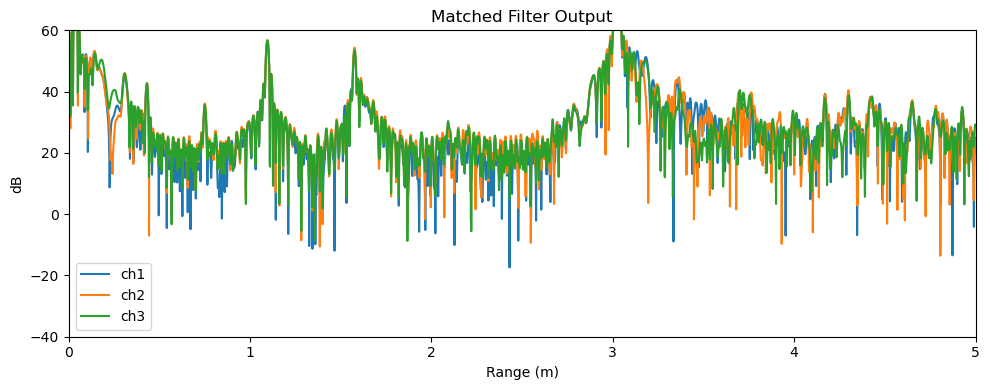

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Rmf, cc_dB)
ax.set_xlim([0, 5])
ax.set_ylim([-40, 60])
ax.set_xlabel('Range (m)')
ax.set_ylabel('dB')
ax.set_title('Matched Filter Output')
ax.legend(['ch1', 'ch2', 'ch3'])
plt.tight_layout()
plt.show()

## 10 — Define range windows (noise & target gates)

The **noise window** now uses the automatically detected `empty_shallow` region instead of the previously hard-coded 0.6 m center.  
The **38 mm target window** remains hard-coded at 1.57 m ± 0.25 m.

In [11]:
# ---- Noise window (from empty_shallow utility) ----
noise_band = empty_shallow_band

# ---- 38 mm target window (already defined in section 7) ----
# target_38mm_band = [1.32, 1.82]

print(f'Noise band (empty_shallow): {noise_band}')
print(f'38 mm target band:          {target_38mm_band}')

Noise band (empty_shallow): [np.float64(0.706417), np.float64(0.956417)]
38 mm target band:          [1.32, 1.82]


## 11 — Plot MF envelope with range gates

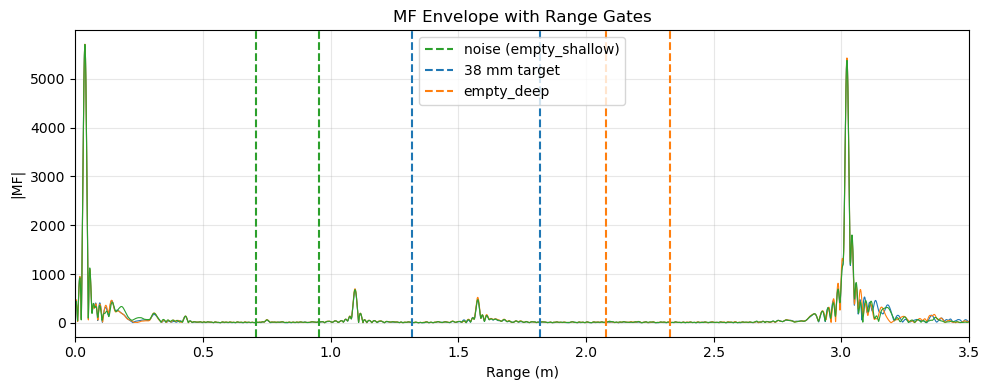

In [12]:
MFmag = np.abs(hilbert(C, axis=0))       # envelope of MF per channel

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Rmf, MFmag, linewidth=0.8)

# Noise gate (empty_shallow) — green
ax.axvline(noise_band[0], color=CLR_NOISE, ls='--', lw=1.5, label='noise (empty_shallow)')
ax.axvline(noise_band[1], color=CLR_NOISE, ls='--', lw=1.5)

# Target gate — blue
ax.axvline(target_38mm_band[0], color=CLR_TARGET, ls='--', lw=1.5, label='38 mm target')
ax.axvline(target_38mm_band[1], color=CLR_TARGET, ls='--', lw=1.5)

# Empty deep gate — orange
ax.axvline(empty_deep_band[0], color=CLR_DEEP, ls='--', lw=1.5, label='empty_deep')
ax.axvline(empty_deep_band[1], color=CLR_DEEP, ls='--', lw=1.5)

ax.set_xlim([0, 3.5])
ax.set_xlabel('Range (m)')
ax.set_ylabel('|MF|')
ax.set_title('MF Envelope with Range Gates')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12 — FFT: ts(f) approximation — per sector

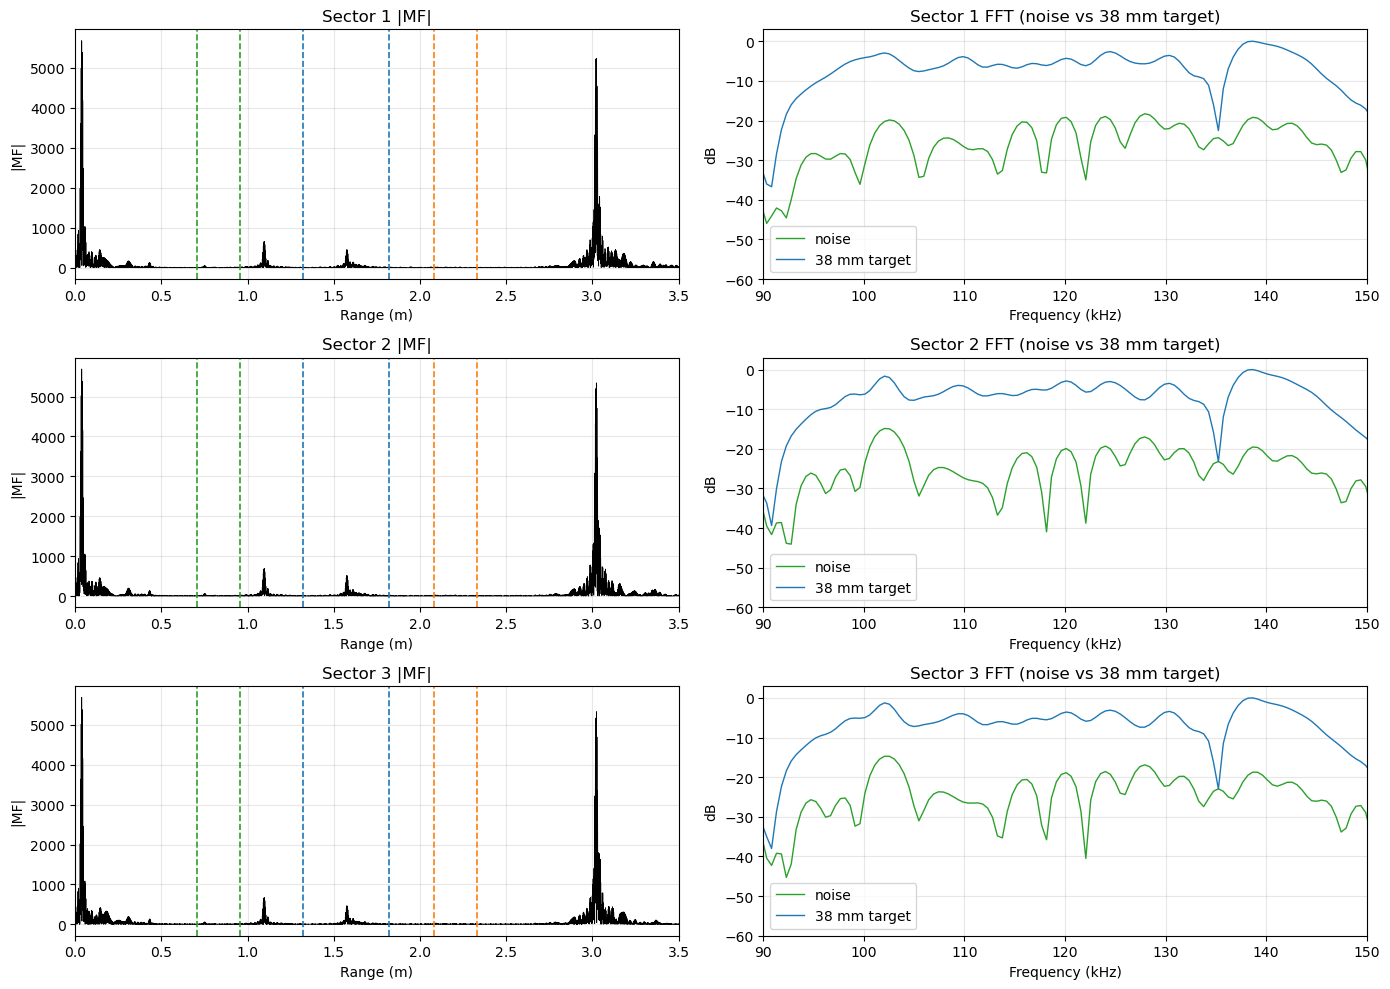

In [15]:
Nfft = 4096
f_Hz = np.arange(Nfft) * (fs / Nfft)

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for ch in range(3):
    m = C[:, ch]                                       # MF for this sector

    # Noise gate indices
    j0n = np.searchsorted(Rmf, noise_band[0])
    j1n = np.searchsorted(Rmf, noise_band[1], side='right') - 1

    # Target gate indices
    j0f = np.searchsorted(Rmf, target_38mm_band[0])
    j1f = np.searchsorted(Rmf, target_38mm_band[1], side='right') - 1

    FFTn = np.fft.fft(m[j0n:j1n+1], n=Nfft)
    FFTf = np.fft.fft(m[j0f:j1f+1], n=Nfft)

    all_max = np.max(np.abs(np.concatenate([FFTn, FFTf]))) + 1e-30
    SdB_n = 20 * np.log10(np.abs(FFTn) / all_max)
    SdB_f = 20 * np.log10(np.abs(FFTf) / all_max)

    # Left: |MF| vs range with all gates
    ax_l = axes[ch, 0]
    ax_l.plot(Rmf, np.abs(m), 'k', linewidth=0.6)
    ax_l.axvline(noise_band[0], color=CLR_NOISE, ls='--', lw=1.2)
    ax_l.axvline(noise_band[1], color=CLR_NOISE, ls='--', lw=1.2)
    ax_l.axvline(target_38mm_band[0], color=CLR_TARGET, ls='--', lw=1.2)
    ax_l.axvline(target_38mm_band[1], color=CLR_TARGET, ls='--', lw=1.2)
    ax_l.axvline(empty_deep_band[0], color=CLR_DEEP, ls='--', lw=1.2)
    ax_l.axvline(empty_deep_band[1], color=CLR_DEEP, ls='--', lw=1.2)
    ax_l.set_xlim([0, 3.5])
    ax_l.grid(True, alpha=0.3)
    ax_l.set_title(f'Sector {ch+1} |MF|')
    ax_l.set_xlabel('Range (m)')
    ax_l.set_ylabel('|MF|')

    # Right: FFT spectra — colors match gate colors
    ax_r = axes[ch, 1]
    ax_r.plot(f_Hz / 1e3, SdB_n, linewidth=1, color=CLR_NOISE, label='noise')
    ax_r.plot(f_Hz / 1e3, SdB_f, linewidth=1, color=CLR_TARGET, label='38 mm target')
    ax_r.grid(True, alpha=0.3)
    ax_r.set_xlim([90, 150])
    ax_r.set_ylim([-60, 3])
    ax_r.set_xlabel('Frequency (kHz)')
    ax_r.set_ylabel('dB')
    ax_r.set_title(f'Sector {ch+1} FFT (noise vs 38 mm target)')
    ax_r.legend(loc='best')

plt.tight_layout()
plt.show()

## 13 — FFT: ts(f) approximation — summed sectors

Same processing as section 12 but applied to the coherent sum of the three sector MF outputs.

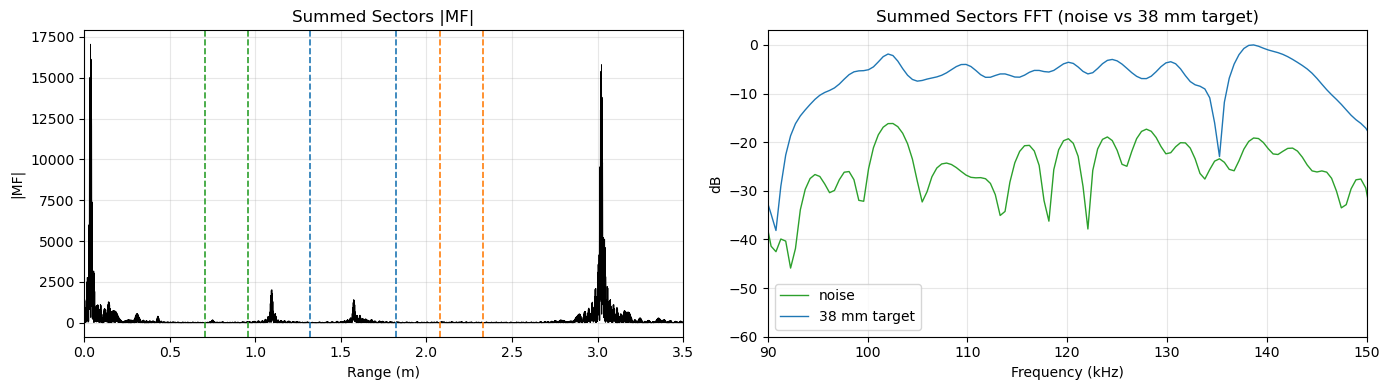

In [16]:
C_sum = C[:, 0] + C[:, 1] + C[:, 2]               # sum of MF across sectors

# Noise gate indices
j0n = np.searchsorted(Rmf, noise_band[0])
j1n = np.searchsorted(Rmf, noise_band[1], side='right') - 1

# Target gate indices
j0f = np.searchsorted(Rmf, target_38mm_band[0])
j1f = np.searchsorted(Rmf, target_38mm_band[1], side='right') - 1

FFTn_sum = np.fft.fft(C_sum[j0n:j1n+1], n=Nfft)
FFTf_sum = np.fft.fft(C_sum[j0f:j1f+1], n=Nfft)

all_max_sum = np.max(np.abs(np.concatenate([FFTn_sum, FFTf_sum]))) + 1e-30
SdB_n_sum = 20 * np.log10(np.abs(FFTn_sum) / all_max_sum)
SdB_f_sum = 20 * np.log10(np.abs(FFTf_sum) / all_max_sum)

fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(14, 4))

# Left: |MF| summed vs range with all gates
ax_l.plot(Rmf, np.abs(C_sum), color='k', linewidth=0.7)
ax_l.axvline(noise_band[0], color=CLR_NOISE, ls='--', lw=1.2)
ax_l.axvline(noise_band[1], color=CLR_NOISE, ls='--', lw=1.2)
ax_l.axvline(target_38mm_band[0], color=CLR_TARGET, ls='--', lw=1.2)
ax_l.axvline(target_38mm_band[1], color=CLR_TARGET, ls='--', lw=1.2)
ax_l.axvline(empty_deep_band[0], color=CLR_DEEP, ls='--', lw=1.2)
ax_l.axvline(empty_deep_band[1], color=CLR_DEEP, ls='--', lw=1.2)
ax_l.set_xlim([0, 3.5])
ax_l.grid(True, alpha=0.3)
ax_l.set_title('Summed Sectors |MF|')
ax_l.set_xlabel('Range (m)')
ax_l.set_ylabel('|MF|')

# Right: FFT spectra — colors match gates
ax_r.plot(f_Hz / 1e3, SdB_n_sum, linewidth=1, color=CLR_NOISE, label='noise')
ax_r.plot(f_Hz / 1e3, SdB_f_sum, linewidth=1, color=CLR_TARGET, label='38 mm target')
ax_r.grid(True, alpha=0.3)
ax_r.set_xlim([90, 150])
ax_r.set_ylim([-60, 3])
ax_r.set_xlabel('Frequency (kHz)')
ax_r.set_ylabel('dB')
ax_r.set_title('Summed Sectors FFT (noise vs 38 mm target)')
ax_r.legend(loc='best')

plt.tight_layout()
plt.show()

## 14 — Noise characterization (multi-ping)

For every ping in the file, compute:
- Peak voltage envelope at the **tank floor**
- Mean voltage envelope in the **empty_deep** window (quiet region below the target)

Plot the ratio (floor peak / empty-window mean) vs ping index as a time-series indicator of ping-to-ping noise stability.

In [17]:
# Range indices for the tank-floor search region and the empty_deep window
floor_search_lo = target_38mm_band[1] + 0.3
floor_search_hi = 5.0            # generous upper bound
i_floor_lo = np.searchsorted(Range, floor_search_lo)
i_floor_hi = np.searchsorted(Range, floor_search_hi, side='right')

i_empty_lo = np.searchsorted(Range, empty_deep_band[0])
i_empty_hi = np.searchsorted(Range, empty_deep_band[1], side='right')

floor_peak  = np.zeros(Npings)
empty_mean  = np.zeros(Npings)

for p in range(Npings):
    # Bandpass filter the 3 sectors for this ping
    d1 = bandpass_filter(data[:, 0, p])
    d2 = bandpass_filter(data[:, 1, p])
    d3 = bandpass_filter(data[:, 2, p])
    env = np.abs(d1) + np.abs(d2) + np.abs(d3)

    floor_peak[p] = np.max(env[i_floor_lo:i_floor_hi])
    empty_mean[p] = np.mean(env[i_empty_lo:i_empty_hi])

ratio = floor_peak / (empty_mean + 1e-30)

print(f'Processed {Npings} pings')
print(f'Floor peak range:  [{floor_peak.min():.4f}, {floor_peak.max():.4f}]')
print(f'Empty mean range:  [{empty_mean.min():.6f}, {empty_mean.max():.6f}]')
print(f'Ratio range:       [{ratio.min():.1f}, {ratio.max():.1f}]')

Processed 100 pings
Floor peak range:  [17.8461, 18.5384]
Empty mean range:  [0.360748, 0.388673]
Ratio range:       [46.2, 51.4]


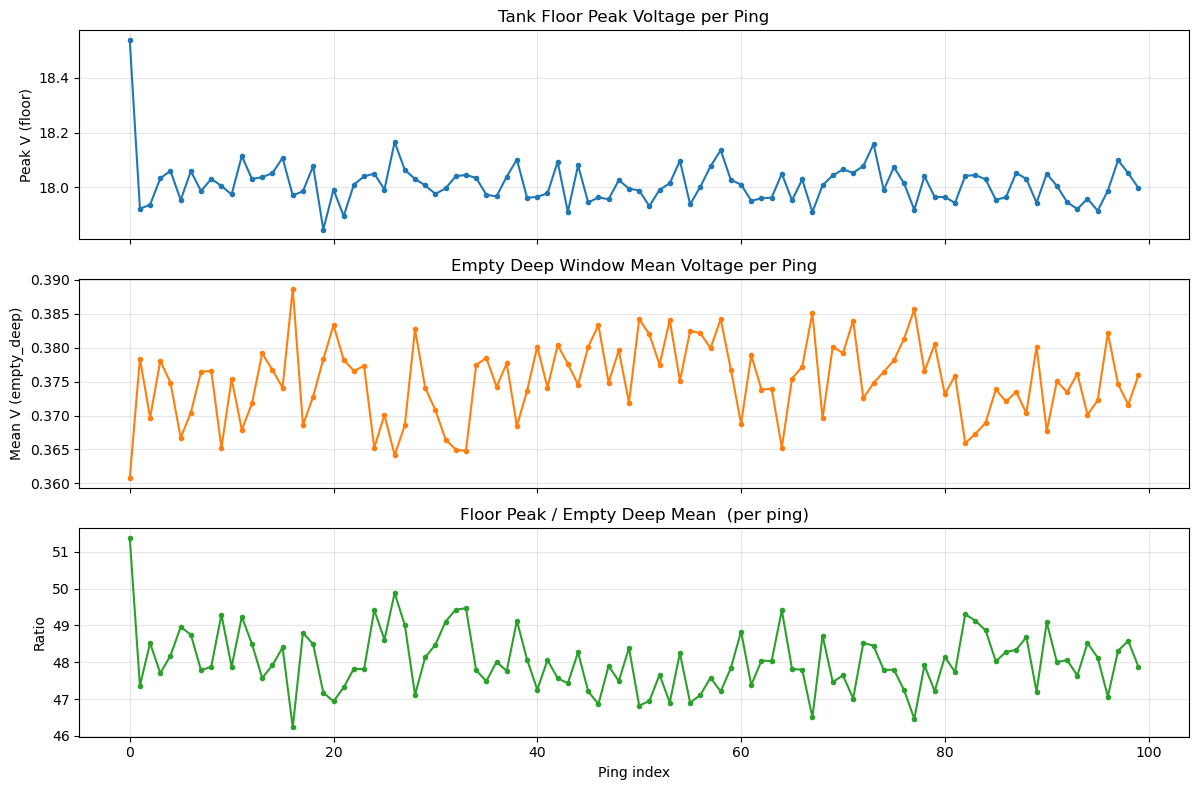

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(np.arange(Npings), floor_peak, 'o-', markersize=3)
axes[0].set_ylabel('Peak V (floor)')
axes[0].set_title('Tank Floor Peak Voltage per Ping')
axes[0].grid(True, alpha=0.3)

axes[1].plot(np.arange(Npings), empty_mean, 'o-', markersize=3, color='#ff7f0e')
axes[1].set_ylabel('Mean V (empty_deep)')
axes[1].set_title('Empty Deep Window Mean Voltage per Ping')
axes[1].grid(True, alpha=0.3)

axes[2].plot(np.arange(Npings), ratio, 'o-', markersize=3, color='#2ca02c')
axes[2].set_ylabel('Ratio')
axes[2].set_xlabel('Ping index')
axes[2].set_title('Floor Peak / Empty Deep Mean  (per ping)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15 — Tank floor SNR (voltage-domain)

Signal-to-noise ratio computed from the filtered voltage envelopes using the
standard voltage-domain formula:

$$\mathrm{SNR_{dB}} = 20 \, \log_{10}\!\left(\frac{V_{\text{signal}}}{V_{\text{noise}}}\right)$$

where:
- **V_signal** = peak voltage envelope in the tank-floor region (the strongest reflector beyond the target)
- **V_noise** = RMS voltage envelope in the `empty_deep` window (signal-free water column below the target, above the floor)

This is the correct formulation when working with amplitude / voltage quantities
(as opposed to power, which would use `10·log₁₀`).  A per-ping time series and
a summary histogram are shown below.

SNR (dB) — min: 33.3,  max: 34.2,  mean: 33.6,  std: 0.15


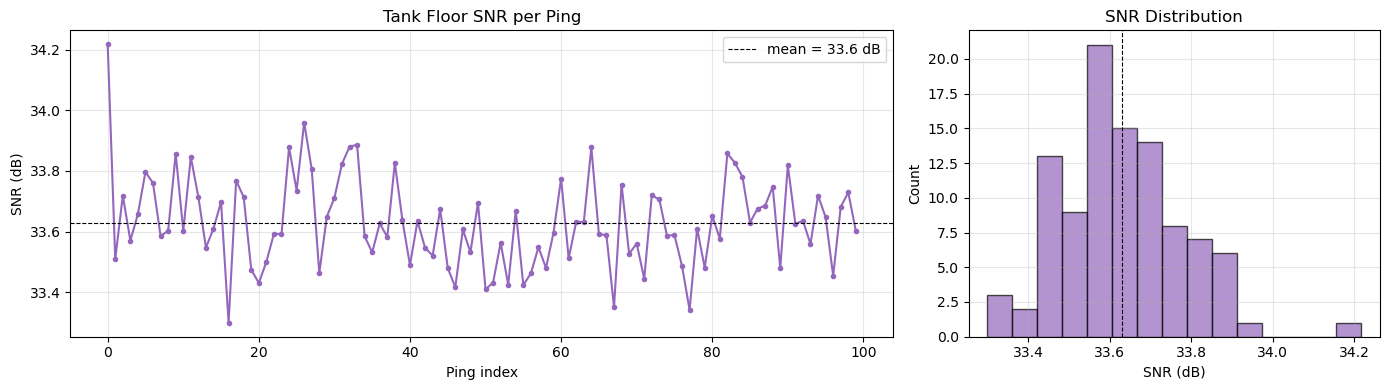

In [19]:
# ---- Compute per-ping SNR (dB) ----
# floor_peak and empty_mean were computed in section 14
SNR_dB = 20 * np.log10(floor_peak / (empty_mean + 1e-30))

print(f'SNR (dB) — min: {SNR_dB.min():.1f},  max: {SNR_dB.max():.1f},  '
      f'mean: {SNR_dB.mean():.1f},  std: {SNR_dB.std():.2f}')

# ---- Plot ----
fig, (ax_ts, ax_hist) = plt.subplots(1, 2, figsize=(14, 4),
                                      gridspec_kw={'width_ratios': [2, 1]})

# Left: time series
ax_ts.plot(np.arange(Npings), SNR_dB, 'o-', markersize=3, color='#9467bd')
ax_ts.axhline(SNR_dB.mean(), color='k', ls='--', lw=0.8,
              label=f'mean = {SNR_dB.mean():.1f} dB')
ax_ts.set_xlabel('Ping index')
ax_ts.set_ylabel('SNR (dB)')
ax_ts.set_title('Tank Floor SNR per Ping')
ax_ts.legend(loc='best')
ax_ts.grid(True, alpha=0.3)

# Right: histogram
ax_hist.hist(SNR_dB, bins=15, color='#9467bd', edgecolor='k', alpha=0.7)
ax_hist.axvline(SNR_dB.mean(), color='k', ls='--', lw=0.8)
ax_hist.set_xlabel('SNR (dB)')
ax_hist.set_ylabel('Count')
ax_hist.set_title('SNR Distribution')
ax_hist.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()